Image opened successfully!
Image tensor shape: torch.Size([1, 3, 256, 256])


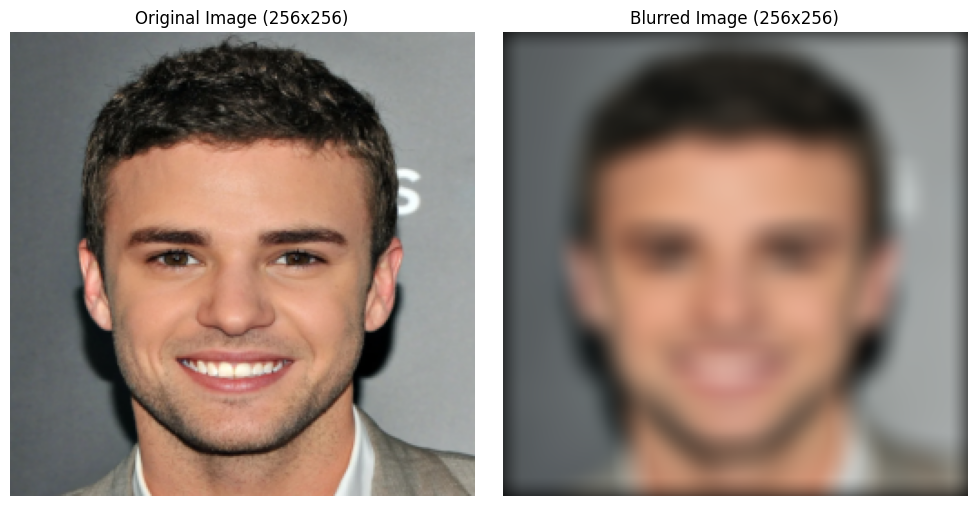

In [5]:
# Import required libraries
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import requests
from PIL import Image
import io
import math

# Define the custom Gaussian blur function (as provided)
def apply_gaussian_blur(images, kernel_size=21, sigma=7.0):
    # Create a Gaussian kernel
    def gaussian_kernel(kernel_size, sigma=1.0):
        x = torch.arange(kernel_size).float() - (kernel_size - 1) / 2
        x = x.view(1, -1).expand(kernel_size, -1)
        y = torch.arange(kernel_size).float() - (kernel_size - 1) / 2
        y = y.view(-1, 1).expand(-1, kernel_size)
        coefficient = 1.0 / (2 * math.pi * sigma**2)
        kernel = coefficient * torch.exp(-(x**2 + y**2) / (2 * sigma**2))
        return kernel / torch.sum(kernel)
    
    # Create a 2D Gaussian kernel
    kernel = gaussian_kernel(kernel_size, sigma)
    kernel = kernel.view(1, 1, kernel_size, kernel_size)
    
    # Get number of channels from input
    num_channels = images.size(1)
    
    # Expand kernel for the appropriate number of channels
    kernel = kernel.repeat(num_channels, 1, 1, 1)
    
    # Apply padding to maintain the same image size
    padding = (kernel_size - 1) // 2
    
    # Apply the kernel to each channel separately
    blurred_images = F.conv2d(
        images, 
        weight=kernel.to(images.device), 
        padding=padding,
        groups=num_channels  # Apply separately to each channel
    )
    
    return blurred_images

url = "https://s1.r29static.com/bin/entry/43a/0,0,2000,2400/1090x1308,85/1536749/image.webp"
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
response = requests.get(url, headers=headers)

if response.status_code == 200:
    # Open the image and convert to RGB
    image = Image.open(io.BytesIO(response.content))
    if image.mode != 'RGB':
        image = image.convert('RGB')
    print("Image opened successfully!")
else:
    print(f"Failed to fetch image. Status code: {response.status_code}")

# Define transforms: resize to 256x256 and convert to tensor
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Apply transforms and add batch dimension
image_tensor = transform(image).unsqueeze(0)  # Shape becomes (1, C, 256, 256)

# Print the shape and number of channels
print(f"Image tensor shape: {image_tensor.shape}")

# Apply Gaussian blur
blurred_image_tensor = apply_gaussian_blur(image_tensor)

# Clamp the output to ensure values stay in [0,1] range
blurred_image_tensor = torch.clamp(blurred_image_tensor, 0, 1)

# Remove the batch dimension for visualization
original_tensor = image_tensor.squeeze(0)  # Shape (C, H, W)
blurred_tensor = blurred_image_tensor.squeeze(0)  # Shape (C, H, W)

# Convert tensors to numpy arrays and permute dimensions for Matplotlib (H, W, C)
original_image = original_tensor.permute(1, 2, 0).numpy()
blurred_image = blurred_tensor.permute(1, 2, 0).numpy()

# Display the original and blurred images side by side
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title("Original Image (256x256)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(blurred_image)
plt.title("Blurred Image (256x256)")
plt.axis('off')

plt.tight_layout()
plt.show()